# Comprehensive Guide on SARSA Reinforcement Learning Algorithm in Python

## Introduction

Reinforcement Learning (RL) is a powerful machine learning paradigm. In RL, a software, usually called an agent, learns to interact with environments to solve complex problems through trial and error, all without human intervention. Among RL algorithms, SARSA stands out for its efficient on-policy nature. 

SARSA stands for State-Action-Reward-State-Action, representing a cycle the agent follows to solve problems. This cycle allows the agent to learn from its past mistakes and occasionally venture out to try new things. This behavior makes the algorithm particularly effective in specific problem types (discussed more later) and differentiates it from off-policy algorithms like Q-learning. 

In this tutorial, you will gain an intuition into how SARSA works and how you can implement it in Python. To make your understanding concrete, we will use a classic Taxi Ride problem throughout. We will also discuss SARSA's advantages, limitations and its real-world applications. 

## What is SARSA? The Short Answer

SARSA, short for State-Action-Reward-State-Action describes a sequence of events in a learning process. It is an effective method for RL computer programs (agents) to make good decisions in various scenarios. 

The main idea behind SARSA is trial and error. The agent takes an action in a situation, observes the result and adjusts its strategy based on the outcome (good or bad). This process is repeated many times, leading to improvements in agent's decisions over time. 

What makes SARSA special among RL algorithms is that SARSA learns from actual choices made by the agent, including when it is trying new things. This approach is particularly useful when the learning journey is just as important as the final result. 

It is like a robot learning to ride a bike by actually riding it, falls and all, instead of finding the shortest path from A to B by using protective training wheels. 

## Setting Up Your Environment For the Tutorial

In this tutorial, we will use Numpy and the Gymnasium reinforcement learning library extensively. While Numpy will help us write the SARSA algorithm, Gymnasium provides us with built-in environments to test our work. 

Let's install them in a new virtual environment with the following commands:

```bash
$ conda create -n sarsa python=3.9 -y
$ conda activate sarsa
$ pip install "gymnasium[atari]" numpy matplotlib
$ pip install autorom[accept-rom-license]  # Downloading Gym env data files
$ AutoROM --accept-license  # Accepting the license for data files
$ pip install ipykernel  # Install Jupyter kernel manager
$ ipython kernel install --user --name=sarsa  # Add the new Conda env to Jupyter
```

Before you continue, I highly encourage you to read our [Introduction to Reinforcement Learning](https://www.datacamp.com/tutorial/reinforcement-learning-python-introduction) article. It covers the fundamental ideas behind RF such as agents, environments, exploration versus exploitation dilemma, and Q-learning.

## Explaining the Taxi-V3 Environment

Throughout the tutorial we will use the Taxi-v3 environment, which is a classic reinforcement learning problem provided by the Gymnasium library. It simulates a taxi driver navigating a 5x5 grid world to pick up and drop off passengers. 

To load the environment, we use the `.make()` method of Gymnasium with an `rgb_array` render mode (to visualize the environment later):

In [61]:
import gymnasium as gym

env = gym.make('Taxi-v3', render_mode='rgb_array')

The environment is a 5x5 grid with 4 designated locations: Red (R), Green (G), Yellow (Y), and Blue (B). The taxi starts at a random square and must pick up a passenger at one of the colored locations and drop them off at another. The taxi can move North, South, East, or West, and can also attempt to pick up or drop off a passenger.

Here is how we can visualize the initial state of the environment with Matplotlib:

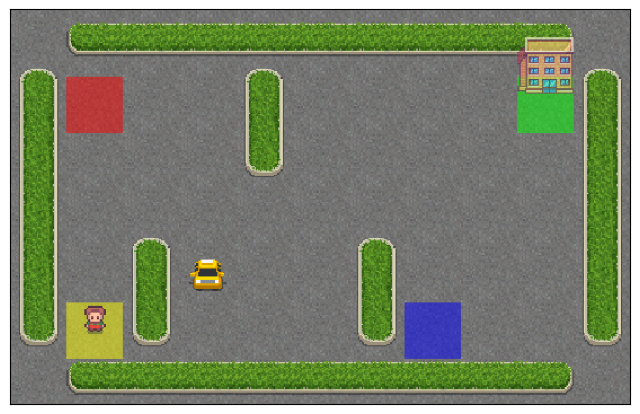

In [62]:
import matplotlib.pyplot as plt

# Reset the environment to get an initial state
initial_state, _ = env.reset()

# Render the initial state
img = env.render()

# Create a figure and display the environment
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img)

# Remove axis ticks
ax.set_xticks([])
ax.set_yticks([]);

First, we reset the environment to get an initial state. Then, we display this initial state with the `render` function, receiving a Numpy image array. Matplotlib's `imshow()` function takes this array and produces a clean visualization without axis ticks. 

Take a moment to understand the layout of the Taxi-v3 grid world, noting the taxi's position, passenger locations, and the destination. 

The agent (the taxi) receives +20 points for successfully dropping off a passenger. Illegal pick-up or drop-off results in -10 reward. All the while, every time step produces -1 reward to encourage the taxi to complete the task quickly.

A single episode of the Taxi-v3 environment terminates in the case of a successful drop-off or when the maximum number of time steps (usually 200) is reached. 

In [64]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print(n_states)
print(n_actions)

500
6


There are 500 states in the environment's state space. Each state is represented by:
- Taxi row (0-4)
- Taxi column (0-4)
- Passenger location (0-3 for R, G, Y, B, or 4 for inside the taxi)
- Destination location (0-3 for R, G, Y, B)

The action codes are:

- 0: Move South
- 1: Move North
- 2: Move East
- 3: Move West
- 4: Pickup passenger
- 5: Drop off passenger

The goal is for the agent to learn an optimal policy to maximize its total reward by efficiently picking up and dropping off passengers.

## SARSA Interaction Loop

Before we write the full algorithm, let's see how the State-Action-Reward-State-Action cycle works using our environment.

First, we define how many episodes we want the interaction to continue. A single episode represents a complete run of the taxi task, from the initial state to either successfully dropping off the passenger or reaching the maximum number of time steps. Each episode allows the agent to learn from its experiences and improve its strategy.

In [67]:
n_episodes = 5000

Now, we write the interaction loop:

In [68]:
for episode in range(n_episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0
    steps = 0

    while not done:
        # Choose a random action
        action = env.action_space.sample()

        # Take the action and observe the result
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Update total reward and step count
        total_reward += reward
        steps += 1

        # Move to the next state
        state = next_state

    if episode % 1000 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward}, Steps: {steps}")

Episode 0, Total Reward: -812, Steps: 200
Episode 1000, Total Reward: -830, Steps: 200
Episode 2000, Total Reward: -902, Steps: 200
Episode 3000, Total Reward: -522, Steps: 129
Episode 4000, Total Reward: -767, Steps: 200


The above code demonstrates the basic SARSA interaction cycle without implementing any learning algorithm:

1. Reset the environment at the start of each episode - (S), `env.reset()`.
2. Take a random action - (A), `env.step(action)`.
3. Receive reward (R) and the next state (S), `next_state, reward, ... = env.take(action)`.
5. Take action (A) in the new state.

The interaction loop only terminates when the maximum number of time steps is reached because we didn't implement any learning algorithm. The taxi keeps moving around the environment in all directions and performing random actions until the time steps run out. 

## Animating the SARSA Interaction Loop

Before we continue, let's implement a feature to animate our interaction loops. This allows us to visually see the taxi interacting with the environment.

Creating the animation will be a simple progress:
- At each time step, we capture the environment's state in an image array using the `env.render` function. 
- We collect the image arrays in a separate variable.
- Using a library called `moviepy`, we concatenate all image arrays to create a single GIF. 

Let's modify the code:

In [70]:
env = gym.make("Taxi-v3", render_mode="rgb_array")
n_episodes = 1
frames = []  # for animation

for episode in range(n_episodes):
    # Reset the environment
    state, _ = env.reset()
    # Capture the state as an image
    img = env.render()
    frames.append(img)

    done = False
    total_reward = 0
    steps = 0

    while not done:
        # Choose a random action
        action = env.action_space.sample()

        # Take the action and observe the result
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        # Capture the next state as an image
        img = env.render()
        frames.append(img)

        # Update total reward and step count
        total_reward += reward
        steps += 1

        # Move to the next state
        state = next_state

We run the cycle just once as rendering takes too much time. Now, we must have about 201 images inside frames (one extra image for the additional state):

In [71]:
len(frames)

201

Let's turn these images into a GIF using `moviepy` library:

In [75]:
from moviepy.editor import ImageSequenceClip  # pip install moviepy


def create_gif(frames: list, filename, fps=5):
    """
    Creates a GIF animation from a list of RGBA NumPy arrays.

    Args:
        frames: A list of RGBA NumPy arrays representing the animation frames.
        filename: The output filename for the GIF animation.
        fps: The frames per second of the animation (default: 10).
    """

    clip = ImageSequenceClip(frames, fps=fps)
    clip.write_gif(filename, fps=fps)

# Example usage
create_gif(frames, "animation.gif", fps=25)  # saves the GIF locally

MoviePy - Building file animation.gif with imageio.


The `create_gif()` function takes a list of frames and convert them into a GIF using the `ImageSequenceClip` class of `moviepy`. An important parameter is the frames per second, `fps`, which control the duration of the GIF. The more frames per second, the shorter the GIf. 

In the end, we convert a single episode's frames into a GIF with 25 FPS. Here is the result:

![](images/animation.gif)

As you can see, the taxi has no idea of what is doing and didn't even get close to the passenger. Let's give it some brains by adding SARSA into its navigation system.

## Implementing SARSA in Python Step-by-step

We will build the code for SARSA from scratch so that you remember each step clearly.

1. Setting up the Gymnasium environment:

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# Create the Taxi environment
env = gym.make("Taxi-v3", render_mode="rgb_array")

2. Initializing a Q-table

In [2]:
# Initialize Q-table
n_states = env.observation_space.n
n_actions = env.action_space.n
Q_table = np.zeros((n_states, n_actions))

In this step, we introduce a new data structure - the Q-table. It has (number of states) x (number of actions) dimensions. The table would look like this to our agent, the taxi driver:

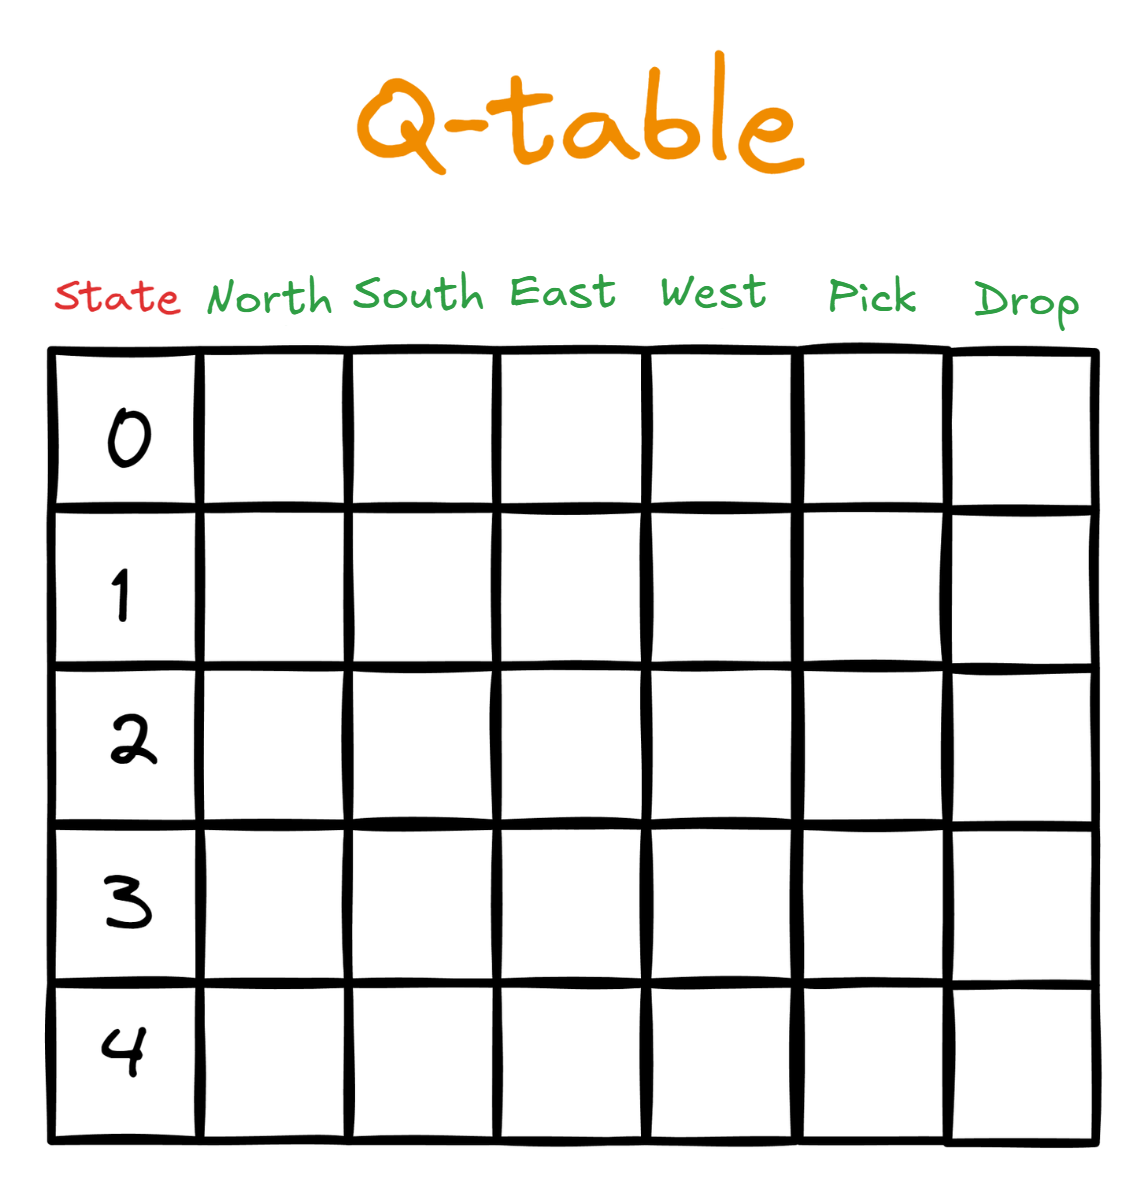

Initially, the Q-table will be filled with zeros:

In [3]:
Q_table.shape

(500, 6)

Then, as the agent starts interacting with the environment guided by SARSA, it will update the Q-table with Q-values. The Q-values are scores that tell the agent which action is the best one to take given the current state. 

3. Defining SARSA hyperparameters

After initializing the Q-table, we set the hyperparameters of SARSA to common values (more on them later):

In [4]:
# SARSA parameters
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 0.1  # Exploration rate for epsilon-greedy policy
n_episodes = 20000

4. Defining storage for performance metrics

Then, we define two lists to store performance metrics: the total reward and the number of time steps for each episode. The agent's goal is to collect as much reward as possible in the shortest time possible:

In [5]:
# Lists to store performance metrics
episode_rewards = []
episode_lengths = []

5. Epsilon-greedy policy for taking action

In the previous section, our agent was unguided - it was taking random actions. We want to change that by giving the driver an Epsilon-Greedy strategy:

In [6]:
def epsilon_greedy(state, epsilon):
    if np.random.random() < epsilon:
        # Take random action - explore
        return env.action_space.sample()
    else:
        # Take action with the highest Q-value - exploit
        return np.argmax(Q_table[state])

This strategy is intended to control the crucial balance between exploration and exploitation. With probability `epsilon`, the agent explores by taking a random action, while with probability `1-epsilon`, it exploits its current knowledge by choosing the action with the highest Q-value. This approach allows the agent to discover new, potentially better strategies while also using what it has already learned.

6. Writing SARSA training loop

Finally, we write the SARSA training loop. The beginning of the loop is already familiar to us. The only difference is that we use the `epsilon_greedy()` function to tell us which action to take in the current state:

In [7]:
# SARSA training loop
for episode in range(n_episodes):
    state, _ = env.reset()
    action = epsilon_greedy(state, epsilon)
    done = False
    total_reward = 0
    steps = 0

    ...

Then, we start the `while` loop that allows us to run the interaction cycle until we reach a termination state:

```python
# SARSA training loop
for episode in range(n_episodes):
    ...

    while not done:
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_action = epsilon_greedy(next_state, epsilon)
```

Inside the `while` loop, we take the action returned by `epsilon_greedy` and receive the next state, the reward for our action and a boolean value for whether the episode terminated or not. 

Then, we come to the crucial part - SARSA's update rule:

```python
# SARSA training loop
for episode in range(n_episodes):
    ...

    while not done:
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_action = epsilon_greedy(next_state, epsilon)

        # SARSA update rule
        Q_table[state, action] += alpha * (
            reward + gamma * Q_table[next_state, next_action] - Q_table[state, action]
        )
```

The update rule comes from the following formula:

![](https://media.licdn.com/dms/image/v2/D5612AQFayP2BwR5-0w/article-inline_image-shrink_1500_2232/article-inline_image-shrink_1500_2232/0/1668557489531?e=1730332800&v=beta&t=iRcRGC1BbrZ_0t-A053fmXcQCNihPDgUk5Aa3lIKEqM)

[[Source](https://www.linkedin.com/pulse/one-minute-overview-sarsa-algorithm-saulius-dobilas)]

We will learn the intuition behind this formula in the next section. Right now, consider the formula as some math magic that updates the Q-values of our Q-table according to the rules of SARSA. 

Once we make the Q update, we change the `state` and `action` variables to the resulting state and action, add the reward received to total episode reward and increase the number of time steps. 

```python
# SARSA training loop
for episode in range(n_episodes):
    ...

    while not done:
        ...

        state = next_state
        action = next_action
        total_reward += reward
        steps += 1
```

The `while` loop continues until we reach maximum time steps (200 for the taxi environment) or when the taxi successfully drops-off its passenger at the correct location. 

Once the loop terminates, we record the total episode reward and episode length. We also print the average episode reward and length every 1000 episodes:

```python
# SARSA training loop
for episode in range(n_episodes):
    ...

    while not done:
        ...

    episode_rewards.append(total_reward)
    episode_lengths.append(steps)

    if episode % 1000 == 0:
        avg_reward = np.mean(episode_rewards[-1000:])
        avg_length = np.mean(episode_lengths[-1000:])
        print(f"Episode {episode}, Avg Reward: {avg_reward:.2f}, Avg Length: {avg_length:.2f}")
```

Here is the full interaction loop:

In [8]:
# SARSA training loop
for episode in range(n_episodes):
    state, _ = env.reset()
    action = epsilon_greedy(state, epsilon)
    done = False
    total_reward = 0
    steps = 0

    while not done:
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_action = epsilon_greedy(next_state, epsilon)

        Q_table[state, action] += alpha * (
            reward + gamma * Q_table[next_state, next_action] - Q_table[state, action]
        )

        state = next_state
        action = next_action
        total_reward += reward
        steps += 1

    episode_rewards.append(total_reward)
    episode_lengths.append(steps)

    if episode % 2000 == 0:
        avg_reward = np.mean(episode_rewards[-1000:])
        avg_length = np.mean(episode_lengths[-1000:])
        print(f"Episode {episode}, Avg Reward: {avg_reward:.2f}, Avg Length: {avg_length:.2f}")

Episode 0, Avg Reward: -551.00, Avg Length: 185.00
Episode 2000, Avg Reward: -4.37, Avg Length: 19.47
Episode 4000, Avg Reward: 1.98, Avg Length: 15.09
Episode 6000, Avg Reward: 2.29, Avg Length: 14.79
Episode 8000, Avg Reward: 2.06, Avg Length: 14.80
Episode 10000, Avg Reward: 2.16, Avg Length: 14.78
Episode 12000, Avg Reward: 2.06, Avg Length: 14.89
Episode 14000, Avg Reward: 2.33, Avg Length: 14.81
Episode 16000, Avg Reward: 2.36, Avg Length: 14.66
Episode 18000, Avg Reward: 2.53, Avg Length: 14.72


As you can see from the output, the average reward and the number of time steps per episode went down dramatically as we ran more and more episodes. 

We can see this visually by plotting the `episode_rewards` and `episode_lengths` arrays:

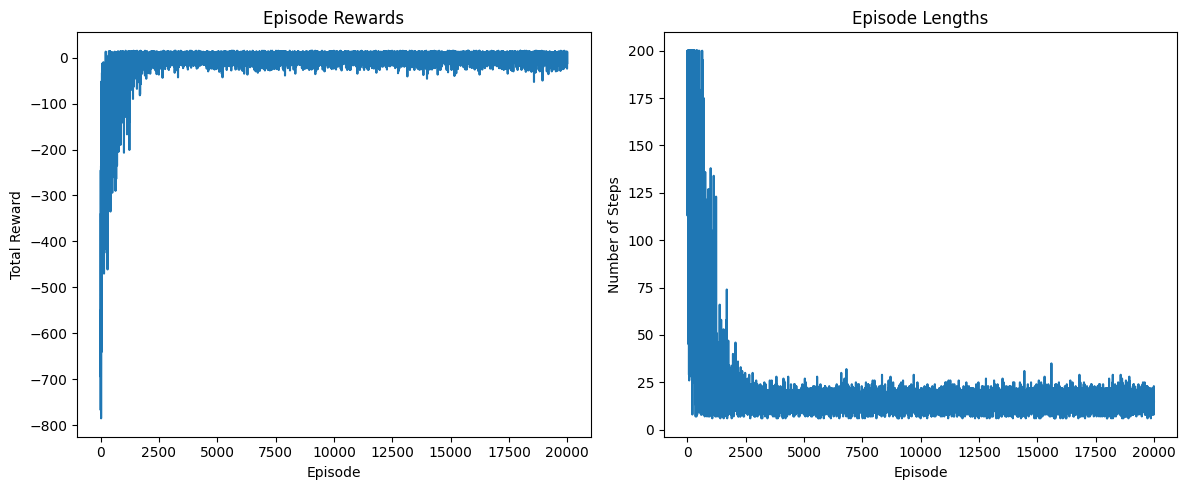

In [9]:
# Plot the learning curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.title("Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")

plt.subplot(1, 2, 2)
plt.plot(episode_lengths)
plt.title("Episode Lengths")
plt.xlabel("Episode")
plt.ylabel("Number of Steps")

plt.tight_layout()
plt.show()

The left plot displays the total reward obtained in each episode. We can observe that:
- Initially, the rewards are low and highly variable, indicating that the agent is exploring and learning.
- Over time, there's an upward trend in the rewards, suggesting that the agent is improving its policy.
- Towards the end, the rewards seem to stabilize at a higher level, indicating that the agent has learned a reasonably good policy.

The right plot shows the number of steps taken in each episode. We can see that:
- At the beginning, episodes tend to be longer, as the agent is taking suboptimal actions.
- As learning progresses, there's a general downward trend in episode length.
- The episode lengths eventually stabilize, suggesting that the agent has learned to complete the task more efficiently.

## Organizing the Code Into Functions

In short duration, we have covered a lot of ground. Let's now take a step back and organize everything we did. We will create functions for each of the steps we took to implement SARSA.

First, a function to create an environment:

In [10]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from moviepy.editor import ImageSequenceClip


def create_environment(env_name="Taxi-v3", render_mode="rgb_array"):
    """Create and return a Gymnasium environment."""
    return gym.make(env_name, render_mode=render_mode)

Then, a function to initialize a Q-table given an environment:

In [11]:
def initialize_q_table(env):
    """Initialize and return a Q-table for the given environment."""
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    return np.zeros((n_states, n_actions))

The Epsilon-greedy strategy that accepts an environment, a Q-table, current state and epsilon:

In [12]:
def epsilon_greedy(env, Q_table, state, epsilon=0.1):
    """Epsilon-greedy action selection."""
    if np.random.random() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q_table[state])

SARSA's update rule which requires a Q-table, the current state, the taken action in that state, the reward for the action, the next state and action:

In [13]:
def sarsa_update(Q_table, state, action, reward, next_state, next_action, alpha, gamma):
    """Perform SARSA update on Q-table."""
    Q_table[state, action] += alpha * (
        reward + gamma * Q_table[next_state, next_action] - Q_table[state, action]
    )

Finally, a large function to train the agent with SARSA that requires an environment, the number of episodes to run, alpha, gamma and epsilon:

In [14]:
def train_sarsa(env, n_episodes=20000, alpha=0.1, gamma=0.99, epsilon=0.1):
    """Train the agent using SARSA algorithm."""
    Q_table = initialize_q_table(env)
    episode_rewards = []
    episode_lengths = []

    for episode in range(n_episodes):
        state, _ = env.reset()
        action = epsilon_greedy(env, Q_table, state, epsilon)
        done = False
        total_reward = 0
        steps = 0

        while not done:
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_action = epsilon_greedy(env, Q_table, next_state, epsilon)

            sarsa_update(
                Q_table, state, action, reward, next_state, next_action, alpha, gamma
            )

            state = next_state
            action = next_action
            total_reward += reward
            steps += 1

        episode_rewards.append(total_reward)
        episode_lengths.append(steps)

    return Q_table, episode_rewards, episode_lengths

Also, a function to plot performance metrics:

In [15]:
def plot_learning_curve(episode_rewards, episode_lengths):
    """Plot the learning curve."""
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards)
    plt.title("Episode Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")

    plt.subplot(1, 2, 2)
    plt.plot(episode_lengths)
    plt.title("Episode Lengths")
    plt.xlabel("Episode")
    plt.ylabel("Number of Steps")

    plt.tight_layout()
    plt.show()

We also paste the `create_gif` function here as a reminder:

In [16]:
def create_gif(frames, filename, fps=5):
    """Creates a GIF animation from a list of frames."""
    clip = ImageSequenceClip(frames, fps=fps)
    clip.write_gif(filename, fps=fps)

And create one other function to run a single episode with rendering using a complete, learned Q-table:

In [17]:
def run_episode(env, Q_table, epsilon=0):
    """Run a single episode using the learned Q-table."""
    state, _ = env.reset()
    done = False
    total_reward = 0
    frames = [env.render()]

    while not done:
        action = epsilon_greedy(env, Q_table, state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        frames.append(env.render())
        total_reward += reward
        state = next_state

    return frames, total_reward

Now, let's execute everything:

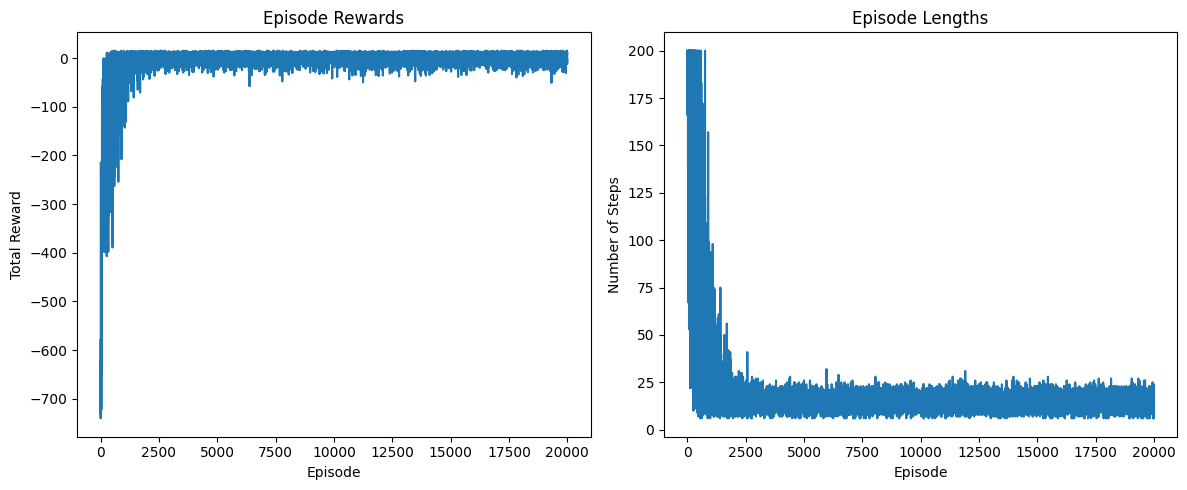

MoviePy - Building file images/sarsa_final_animation.gif with imageio.


In [20]:
if __name__ == "__main__":
    env = create_environment()
    
    Q_table, episode_rewards, episode_lengths = train_sarsa(env, n_episodes=20000)
    plot_learning_curve(episode_rewards, episode_lengths)
    
    frames, total_reward = run_episode(env, Q_table)
    create_gif(frames, "images/sarsa_final_animation.gif", fps=1)

The performance plots look good. Now, let's look at the generated GIF:

![](images/sarsa_final_animation.gif)

Hooray! The taxi is correctly picking up the passenger from the green square and dropping them off at the blue square.

I've pasted the [entire organized code for implementing SARSA](https://gist.github.com/BexTuychiev/1296693d7b50e000aaecf894c3d9537d) into a GitHub gist so that you can return to it any time you want. 

## The Intuition Behind SARSA's Update Rule

At the heart of SARSA lies its update rule, which controls how the agent learns from its experiences. Let's break down this rule and explore the intuition behind it:

```python
Q(s, a) = Q(s, a) + α [R + γ Q(s', a') - Q(s, a)]
```

### Understanding the Components

- Q(s, a): The current Q-value  of taking action 'a' in state 's'.
- α (alpha): The learning rate, controlling how quickly new information is incorporated.
- R: The reward received after taking the action.
- γ (gamma): The discount factor, determining the importance of future rewards.
- Q(s', a'): The estimated Q-value of the next state-action pair.

### The Learning Process

SARSA's update rule aims to refine the agent's understanding of the environment by adjusting Q-values based on new experiences. Here's how it works:

1. The agent takes an action and observes the reward and next state.
2. It calculates the difference between its current Q-value and a new Q-value estimate based on the observed reward and the value of the next state-action pair.
3. This difference, scaled by the learning rate, is used to update the Q-value.

### Temporal Difference Error

The term [R + γ * Q(s', a') - Q(s, a)] is known as the temporal difference (TD) error. Think of it as a measure of surprise:

- Positive TD error: The outcome was better than expected.
- Negative TD error: The outcome was worse than expected.
- Zero TD error: The outcome matched the current estimate perfectly.

This error helps the agent continuously refine its estimates, driving the learning process towards an optimal policy.

### Role of Hyperparameters

1. Learning rate (α):
   - Controls the speed of learning.
   - Higher α: Faster learning, but potentially unstable.
   - Lower α: Slower, more stable learning.

2. Discount factor (γ):
   - Balances immediate and future rewards.
   - γ close to 1: Agent values future rewards almost as much as immediate ones.
   - Lower γ: Agent focuses more on immediate rewards.

3. Exploration rate (ε):
   - While not in the update rule itself, it's crucial for the epsilon-greedy policy.
   - Balances exploration (trying new actions) and exploitation (using known good actions).
   - Higher ε: More exploration, potentially discovering better strategies at the cost of short-term performance.

### The Big Picture

SARSA's update rule allows the agent to learn from its experiences by constantly adjusting its estimates of state-action values. With each interaction, the agent becomes a little bit wiser about its environment. Over many episodes, this process leads to the development of an optimal policy for navigating the environment.

By tuning the hyperparameters, we can control various aspects of the learning process, allowing SARSA to adapt to different types of problems and environments. This flexibility, combined with its intuitive update rule, makes SARSA a powerful and widely-used reinforcement learning algorithm.

## SARSA vs. Q-learning: Key Differences

Though SARSA and Q-learning are both widely used reinforcement learning algorithms, they do have some important differences. And those differences are critical to understanding when and how to use each algorithm.

1. On-policy vs. Off-policy:

An on-policy algorithm, SARSA learns the value of the policy it follows, including even the steps taken during exploration. Q-learning is off-policy; it learns the value of the optimal policy—even when it's not following that policy, it still learns the value of the optimal policy when it ultimately reaches the end of the episode. That's why we mentioned in the beginning that SARSA must be used when the learning journey is just as important as the outcome itself. Q-learning doesn't care about the learning journey much.

2. Update Rule:

- SARSA: Q(s, a) = Q(s, a) + α * [R + γ * Q(s', a') - Q(s, a)]
- Q-learning: Q(s, a) = Q(s, a) + α * [R + γ * max(Q(s', a')) - Q(s, a)]

The key difference is that SARSA uses the Q-value of the next action actually taken (a'), while Q-learning uses the maximum Q-value of the next state (max(Q(s', a'))).

3. Exploration Consideration:

When updating the Q-values, SARSA does not ignore the exploration policy and is thus more conservative. In comparison, Q-learning always assumes that the agent will take the optimal action in the future and is therefore more aggressive.

4. Convergence:

While both algorithms eventually reach the optimal policy, Q-learning can often learn more quickly, particularly in deterministic environments.

5. Safety:

In environments where exploration can lead to bad outcomes, SARSA generally learns safer policies because it takes into account the actual policy being followed.

In the classic "cliff walking" problem, SARSA typically learns a safer path that stays away from the cliff edge, while Q-learning might learn a riskier path that walks along the edge.

6. Stability:

In certain random environments, SARSA can be more stable because it takes into account the actual next action, even when that action is a suboptimal exploratory one.

7. Hyperparameter Sensitivity:

Q-learning can be more sensitive to the choice of learning rate and exploration rate, especially in environments with significant stochasticity.

8. Real-world Applications:

When it comes to robotics or other physical systems where exploring the environment is costly and we want to implement safer policies, we might prefer the on-policy algorithm SARSA. When we are in the simulated world, in games, or in other environments where we can get a lot of feedback and where we want to find the optimal policy in a way that is fast and somewhat safe, we might like Q-learning a lot better.

So you might think that SARSA is sort of the safer province, and Q-learning is the faster, more reckless approach. In practice, it often depends on the specific problem. Both algorithms are very strong, and it always makes sense to know what the differences between them are.

## Conclusion

In this comprehensive guide, we've explored the SARSA algorithm, covering its core concepts, implementation details, and practical applications using the Taxi-v3 environment.

Key takeaways include:

1. SARSA's on-policy nature and its update rule intuition
2. Python implementation and visualization techniques
3. Comparison with Q-learning, highlighting strengths and use cases

SARSA's ability to learn safer policies makes it suitable for real-world applications where exploration costs are high, though it may converge slower than off-policy algorithms like Q-learning in some scenarios.

Remember, choosing between SARSA and other algorithms depends on your specific problem and environment. Experimentation and fine-tuning are crucial for optimal results.

We encourage you to build upon this foundation by exploring more complex environments, implementing SARSA with function approximation, or diving into other reinforcement learning algorithms.

Here are some related resources to help you along the way:
- https://www.datacamp.com/tutorial/reinforcement-learning-python-introduction
- https://www.datacamp.com/courses/reinforcement-learning-with-gymnasium-in-python
- https://www.datacamp.com/tutorial/introduction-q-learning-beginner-tutorial
- https://www.datacamp.com/tracks/machine-learning-scientist-with-python
